In [179]:
# Import modules
import numpy as np

# Import functions
from common.assembly_A_local_global_matrices import *
from common.assembly_K_matrices import *
from common.assembly_B_matrices import *
from common.assembly_f_vectors import *
from common.assembly_u_solution import *
from common.RegularSudomainsMesh import RegularSubdomainsMesh
from common.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
# Import data
d_dat = np.genfromtxt('../data/small/d.dat')
fP_dat = np.genfromtxt('../data/small/fP.dat')
fr_dat = np.genfromtxt('../data/small/fr.dat')
Ks = np.genfromtxt('../data/small/localK.dat')
solution = np.genfromtxt('../data/small/solution.dat')

In [181]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])
qs_left_bound = np.array([0, 8])
qs_right = np.array([3, 11])

In [182]:
# Create mesh
mesh = RegularSubdomainsMesh(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [183]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(mesh)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(mesh)

# Dirichlet nodes local-global transformation matrices
ADd = create_ADq_matrices(mesh)

In [184]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs, mesh)

In [185]:
KPP = assembly_KPP_matrix(Ks, APq, qs, qs_right, mesh)

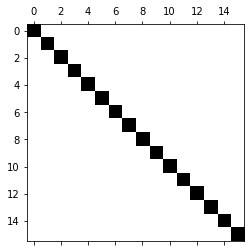

In [186]:
plt.spy(KPP)

In [187]:
KRP, Krqs_list = assembly_KRP_matrix(Ks, APq, ARr, qs, qs_right, rs, mesh)

In [188]:
KPR = KRP.T

In [189]:
KPD = assembly_KPD_matrix(Ks, APq, ADd, qs_left_bound, qs_right, mesh)
KRD = assembly_KRD_matrix(Ks, ARr, ADd, qs_left_bound, rs, mesh)

In [190]:
# Plot K matrices
# plot_sparse_matrix(KRR, 'KRR')
# plot_sparse_matrix(KPP, 'KPP')
# plot_sparse_matrix(KPR, 'KPR')
# plot_sparse_matrix(KPD, 'KPD')
# plot_sparse_matrix(KRD, 'KRD')

In [191]:
# Assembly B matrices
BlambdaR, Brs_list = assembly_BR_matrix(mesh, ARr)

# Dirichlet boundary conditions
# Left wall remaining
BlambdaR, BRs_list = assembly_Dirichlet_BR_matrix(mesh, ARr, BlambdaR, Brs_list)

#Left wall primal
# BlambdaP = assembly_Dirichlet_BP_matrix(mesh, ADd)

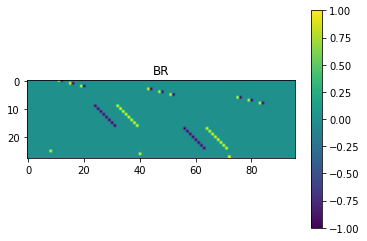

In [192]:
# Plot B matrix
plot_sparse_matrix(BlambdaR, 'BR')

In [193]:
# Assembly d vector
d = np.zeros(mesh.Nlambda)
d[mesh.NlambdaR:] = d_dat[np.arange(len(d_dat)) % (mesh.Nr_y - 1) != 0]

In [194]:
# Assembly f vectors
# fP
fP, fD = assembly_fP_fD_vectors(mesh, fP_dat)

# fR
fR = assembly_fR_vector(mesh, fr_dat)

In [195]:
# Assembly uD vector
uD = d_dat[np.arange(len(d_dat)) % (mesh.Nr_y - 1) == 0]

In [196]:
# Matrices pre computation
from scipy.sparse.linalg import inv
from scipy.sparse import identity

KRR_inv = np.linalg.inv(KRR)
# KRR_inv = inv(KRR)

SPP = KPP - KPR @ KRR_inv @ KRP
SPP_inv = np.linalg.inv(SPP)
# SPP_inv = inv(SPP)

fPH = fP - KPD @ uD
fRH = fR - KRD @ uD

IR = np.eye(mesh.NR) # RxR identity matrix
# IR = identity(mesh.NR)

dH = d - BlambdaR @ KRR_inv @ ((IR + KRP @ SPP_inv @ KPR @ KRR_inv) @ fRH - KRP @ SPP_inv @ fPH)
F = -BlambdaR @ KRR_inv @ (KRP @ SPP_inv @ KPR @ KRR_inv + IR) @ BlambdaR.T

In [197]:
# Print some matrices
# plot_sparse_matrix(SPP, 'SPP')
# plot_sparse_matrix(SPP_inv, 'SPP inverse')
# plot_sparse_matrix(F, 'F')

In [198]:
# System matrix check

# zerosP = np.zeros((mesh.NP, mesh.NP))
# zerosLambda = np.zeros((mesh.Nlambda, mesh.Nlambda))
# zerosLambdaP = np.zeros((mesh.Nlambda, mesh.NP))

# system_row0 = np.concatenate((zerosLambda, zerosLambdaP, BlambdaR), axis=1)
# system_row1 = np.concatenate((zerosLambdaP.T, KPP, KPR), axis=1)
# system_row2 = np.concatenate((BlambdaR.T, KRP, KRR), axis=1)

# system = np.concatenate((system_row0, system_row1, system_row2), axis=0)

# plot_sparse_matrix(system)
# np.linalg.det(system)

In [199]:
# Solve lambda linear system
lambda_ = np.linalg.solve(F, dH)

In [200]:
# Compute u
# uP
uP = SPP_inv @ (fPH - KPR @ KRR_inv @ fRH + KPR @ KRR_inv @ BlambdaR.T @ lambda_)

# uR
uR = KRR_inv @ (IR + KRP @ SPP_inv @ KPR @ KRR_inv) @ fRH \
    - KRR_inv @ KRP @ SPP_inv @ fPH \
    - KRR_inv @ (IR + KRP @ SPP_inv @ KPR @ KRR_inv) @ BlambdaR.T @ lambda_

In [201]:
# Assembly u using real global coordinates
u = assembly_u_solution(mesh, uD, uP, uR, BlambdaR)

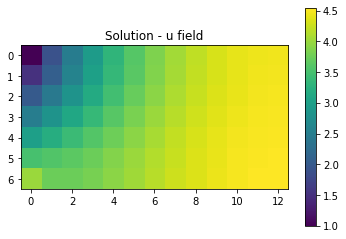

In [202]:
# Plot solution field as a matrix
u_mat = u.reshape((mesh.Ntot_y, mesh.Ntot_x))
plot_sparse_matrix(u_mat, 'Solution - u field')

In [203]:
# Compare results with actual solution to check
if np.allclose(u, solution):
    print('The solution provided is as expected!')
else:
    print('Solution is not correct')

The solution provided is as expected!
